In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import hdbscan
from cartopy import crs as ccrs
from cartopy.io.img_tiles import OSM
from sklearn.preprocessing import LabelEncoder
from matplotlib.patches import Patch

taxi_dataset = pd.read_csv('yellow_tripdata_2015-09.csv')

C:\Users\Brent\AppData\Local\Temp\ipykernel_15492\2389567739.py:13: DtypeWarning: Columns (1,2,8) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi_dataset = pd.read_csv('yellow_tripdata_2015-09.csv')


New column: Trip Duration

In [2]:
for i in taxi_dataset.columns[[1, 2]]:
    taxi_dataset[i] = pd.to_datetime(taxi_dataset[i], format='%Y-%m-%d %H:%M:%S')

timedeltas = taxi_dataset['tpep_dropoff_datetime'] - taxi_dataset['tpep_pickup_datetime']
trip_duration = []
for i in timedeltas:
    trip_duration.append(i.total_seconds() / 60)

taxi_dataset['trip_duration'] = trip_duration
taxi_dataset['trip_duration'] = taxi_dataset['trip_duration'].round(2)

Data Cleaning

In [3]:
taxi_dataset = taxi_dataset[taxi_dataset['trip_duration'] > 1]
taxi_dataset = taxi_dataset[taxi_dataset['passenger_count'] > 0]
taxi_dataset = taxi_dataset[taxi_dataset['fare_amount'] > 0]
taxi_dataset = taxi_dataset[taxi_dataset['total_amount'] > 0]
taxi_dataset = taxi_dataset[(taxi_dataset.trip_duration < 5900)]

# removing locations that are outside new york city
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]

taxi_dataset = taxi_dataset[(taxi_dataset.pickup_longitude > xlim[0]) & (taxi_dataset.pickup_longitude < xlim[1])]
taxi_dataset = taxi_dataset[(taxi_dataset.dropoff_longitude > xlim[0]) & (taxi_dataset.dropoff_longitude < xlim[1])]
taxi_dataset = taxi_dataset[(taxi_dataset.pickup_latitude > ylim[0]) & (taxi_dataset.pickup_latitude < ylim[1])]
taxi_dataset = taxi_dataset[(taxi_dataset.dropoff_latitude > ylim[0]) & (taxi_dataset.dropoff_latitude < ylim[1])]

In [4]:
taxi_dataset.shape

(738656, 20)

In [5]:
taxi_dataset.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       2.0  2015-09-01 00:05:00   2015-09-01 00:31:00              1.0   
1       1.0  2015-09-01 00:05:00   2015-09-01 00:07:00              1.0   
2       1.0  2015-09-01 00:05:00   2015-09-01 00:16:00              1.0   
4       1.0  2015-09-01 00:05:00   2015-09-01 00:30:00              1.0   
5       2.0  2015-09-01 00:05:00   2015-09-01 00:12:00              3.0   

   trip_distance  pickup_longitude  pickup_latitude  RatecodeID  \
0          17.45        -73.791351        40.646690         1.0   
1           0.40        -73.978935        40.752853         1.0   
2           1.50        -73.990891        40.723972         1.0   
4           7.50        -73.987778        40.738194         1.0   
5           1.61        -73.990257        40.737289         1.0   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.857437         40.848263           1.0   
1                  N         -73.986061         40.755398           2.0   
2                  N         -74.009560         40.728916           2.0   
4                  N         -73.944756         40.828167           1.0   
5                  N         -73.995087         40.744850           2.0   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         47.5    0.5      0.5        5.00          5.54   
1          3.5    0.5      0.5        0.00          0.00   
2          9.0    0.5      0.5        0.00          0.00   
4         23.5    0.5      0.5        4.95          0.00   
5          7.0    0.5      0.5        0.00          0.00   

   improvement_surcharge  total_amount  trip_duration  
0                    0.3         59.34           26.0  
1                    0.3          4.80            2.0  
2                    0.3         10.30           11.0  
4                    0.3         29.75           25.0  
5                    0.3          8.30            7.0

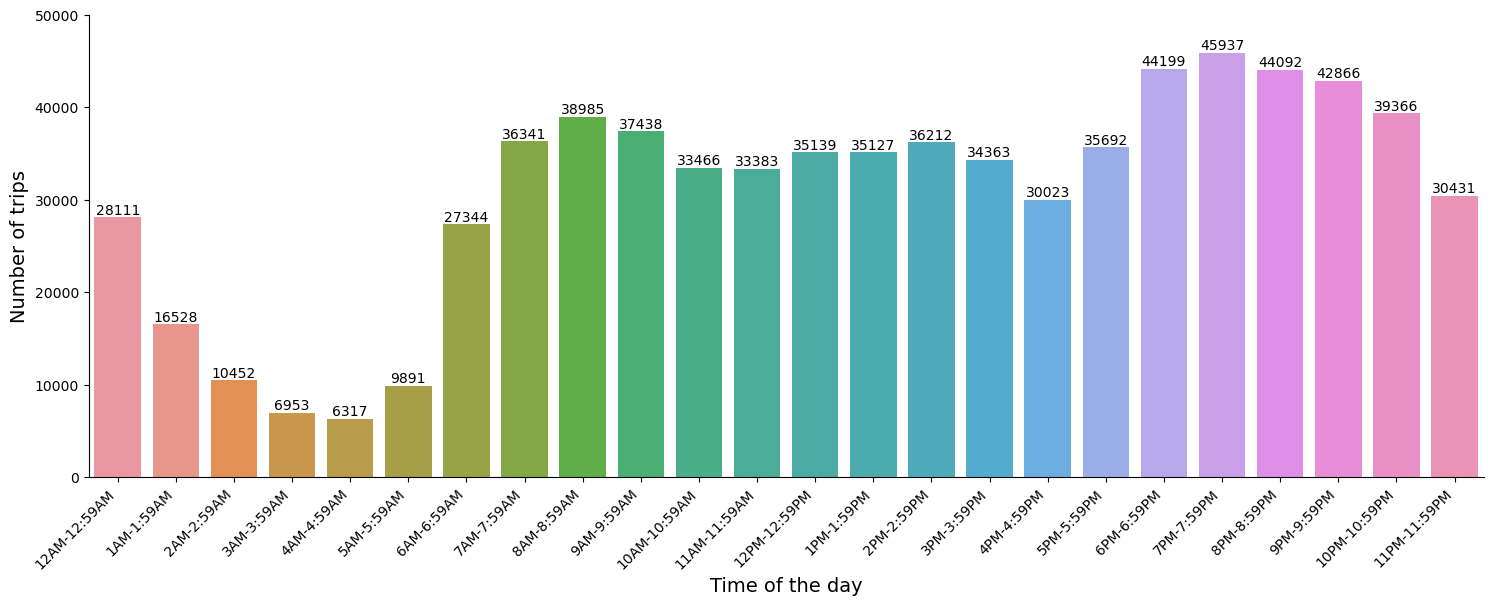

In [24]:
#Pickup Hour Distribution
plt.figure(figsize=(18, 6))
graph2 = sns.countplot(x = taxi_dataset['tpep_pickup_datetime'].dt.hour, data=taxi_dataset)
plt.xlabel("Time of the day", fontsize=14)
plt.ylabel("Number of trips", fontsize=14)
tick_labels = [
    f"{i}AM-{i}:59AM" if i < 12 else 
    f"{i-12}PM-{i-12}:59PM" if i > 12 else 
    f"12AM-12:59AM"
    for i in range(24)
]
tick_labels[0] = "12AM-12:59AM"
tick_labels[12] = "12PM-12:59PM"
graph2.set_xticklabels(tick_labels, rotation=45, ha="right")
plt.bar_label(graph2.containers[0])
plt.ylim(0, 50000)

sns.despine()
plt.show()

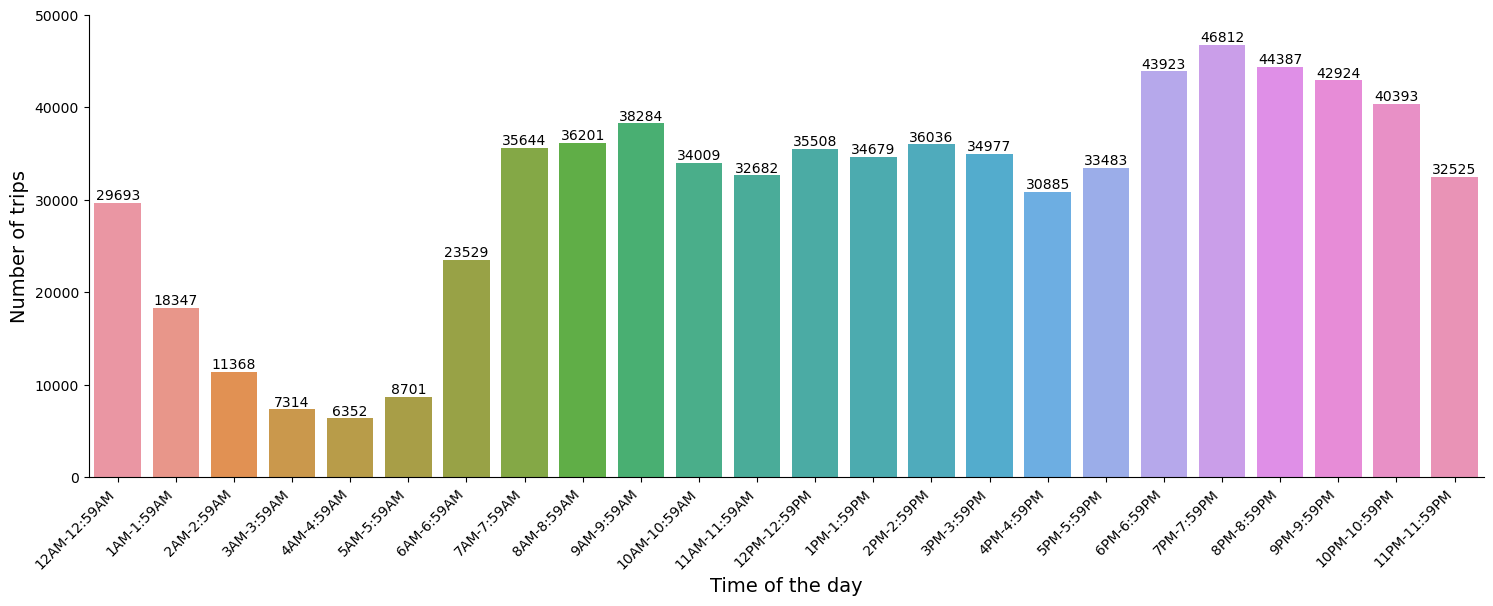

In [25]:
#Dropoff Hour Distribution
plt.figure(figsize=(18, 6))
graph = sns.countplot(x = taxi_dataset['tpep_dropoff_datetime'].dt.hour, data=taxi_dataset)
plt.xlabel("Time of the day", fontsize=14)
plt.ylabel("Number of trips", fontsize=14)
tick_labels = [
    f"{i}AM-{i}:59AM" if i < 12 else 
    f"{i-12}PM-{i-12}:59PM" if i > 12 else 
    f"12AM-12:59AM"
    for i in range(24)
]
tick_labels[0] = "12AM-12:59AM"
tick_labels[12] = "12PM-12:59PM"
graph.set_xticklabels(tick_labels, rotation=45, ha="right")
plt.bar_label(graph.containers[0])
plt.ylim(0, 50000)

sns.despine()
plt.show()

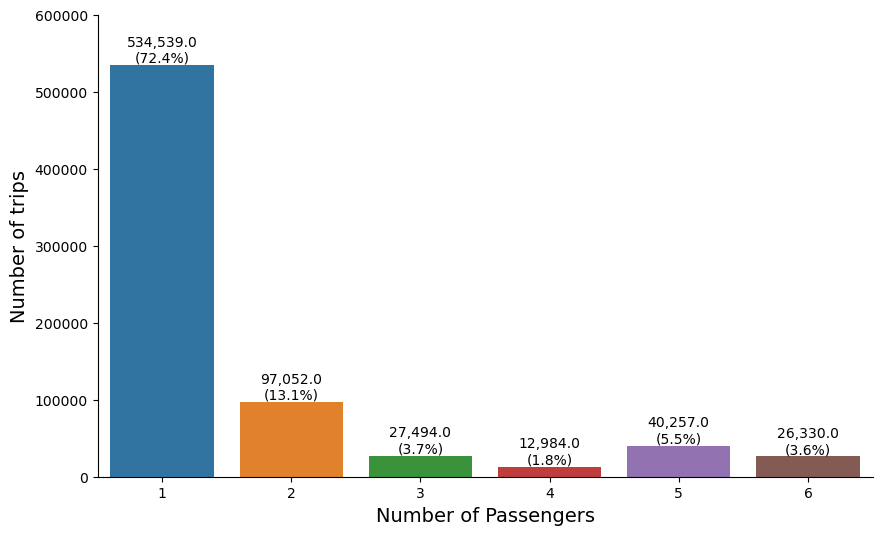

In [5]:
#Passenger Count Distribution
plt.figure(figsize=(10, 6))
taxi_dataset['passenger_count'] = taxi_dataset['passenger_count'].astype(int)
graph3 = sns.countplot(x=taxi_dataset['passenger_count'], data=taxi_dataset)
plt.xlabel("Number of Passengers", fontsize=14)
plt.ylabel("Number of trips", fontsize=14)
total = len(taxi_dataset['passenger_count'])
for container in graph3.containers:
    for i, bar in enumerate(container):
        height = bar.get_height()
        graph3.text(bar.get_x() + bar.get_width()/2, height, f"{height:,}\n({height/total:.1%})", ha="center", va="bottom")
plt.ylim(0, 600000)

sns.despine()
plt.show()

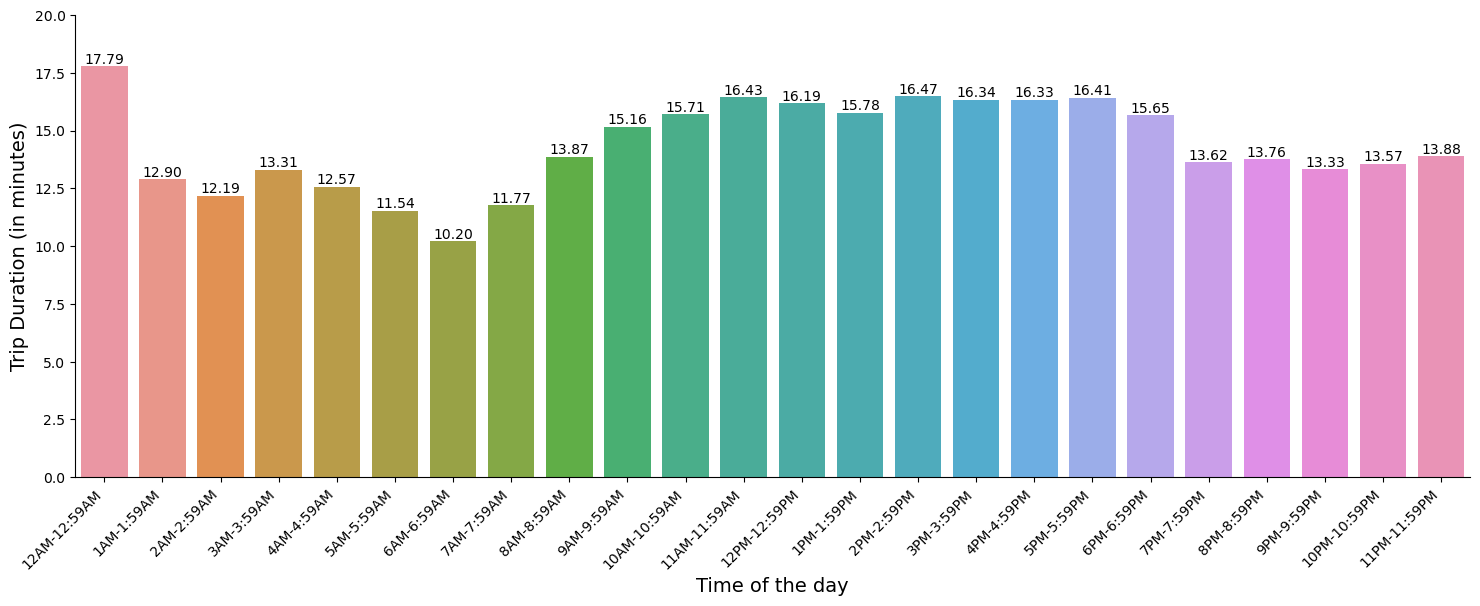

In [13]:
#Trip Duration Distribution
def add_bar_labels(barplot):
    for containers in barplot.containers:
        for bar in containers:
            height = bar.get_height()
            barplot.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha="center", va="bottom")

plt.figure(figsize=(18, 6))
graph7 = sns.barplot(x = taxi_dataset['tpep_dropoff_datetime'].dt.hour, y = taxi_dataset['trip_duration'], data = taxi_dataset, errorbar = None)
plt.xlabel('Time of the day', fontsize=14)
plt.ylabel('Trip Duration (in minutes)', fontsize=14)
plt.ylim(0, 18)

tick_labels = [
    f"{i}AM-{i}:59AM" if i < 12 else 
    f"{i-12}PM-{i-12}:59PM" if i > 12 else 
    f"12AM-12:59AM"
    for i in range(24)
]
tick_labels[0] = "12AM-12:59AM"
tick_labels[12] = "12PM-12:59PM"

graph7.set_xticklabels(tick_labels, rotation=45, ha="right")

add_bar_labels(graph7)

plt.ylim(0, 20)

sns.despine()
plt.show()

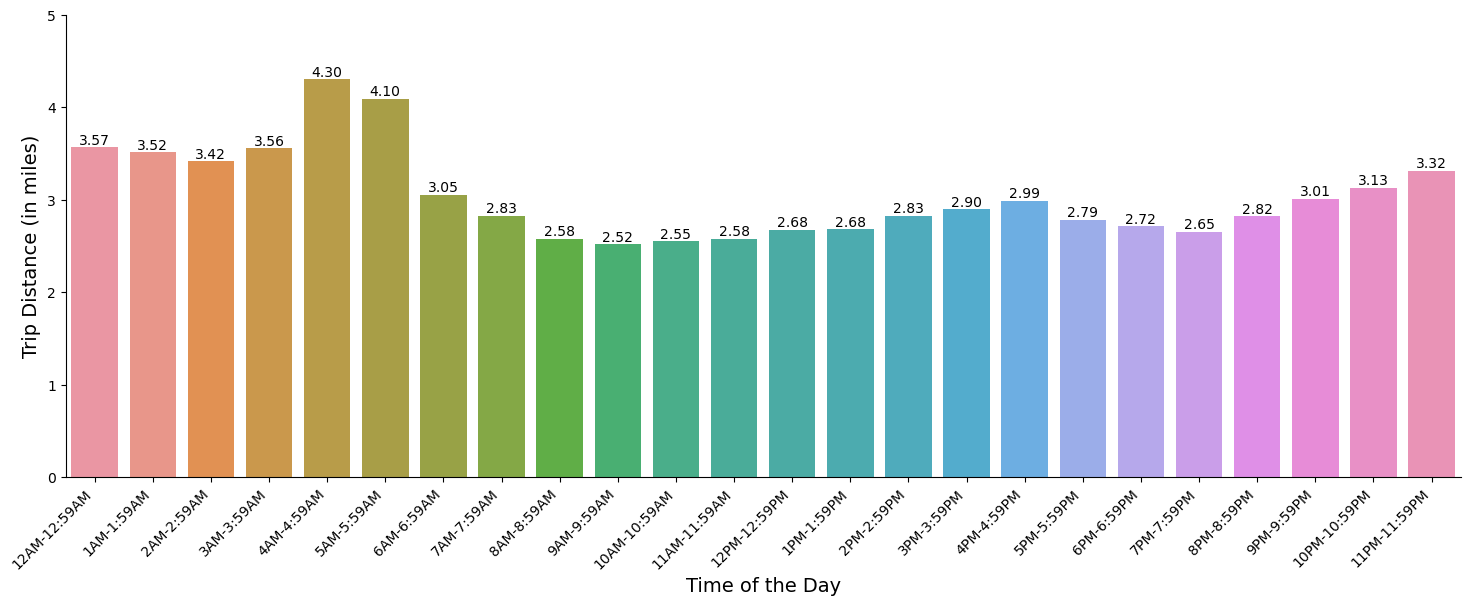

In [14]:
#Trip Distance Distribution
def add_bar_labels(barplot):
    for containers in barplot.containers:
        for bar in containers:
            height = bar.get_height()
            barplot.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha="center", va="bottom")

plt.figure(figsize=(18, 6))
graph7 = sns.barplot(x = taxi_dataset['tpep_dropoff_datetime'].dt.hour, y = taxi_dataset['trip_distance'], data = taxi_dataset, errorbar = None)
plt.xlabel('Time of the Day', fontsize=14)
plt.ylabel('Trip Distance (in miles)', fontsize=14)
plt.ylim(0, 5)

tick_labels = [
    f"{i}AM-{i}:59AM" if i < 12 else 
    f"{i-12}PM-{i-12}:59PM" if i > 12 else 
    f"12AM-12:59AM"
    for i in range(24)
]
tick_labels[0] = "12AM-12:59AM"
tick_labels[12] = "12PM-12:59PM"

graph7.set_xticklabels(tick_labels, rotation=45, ha="right")

add_bar_labels(graph7)

sns.despine()
plt.show()

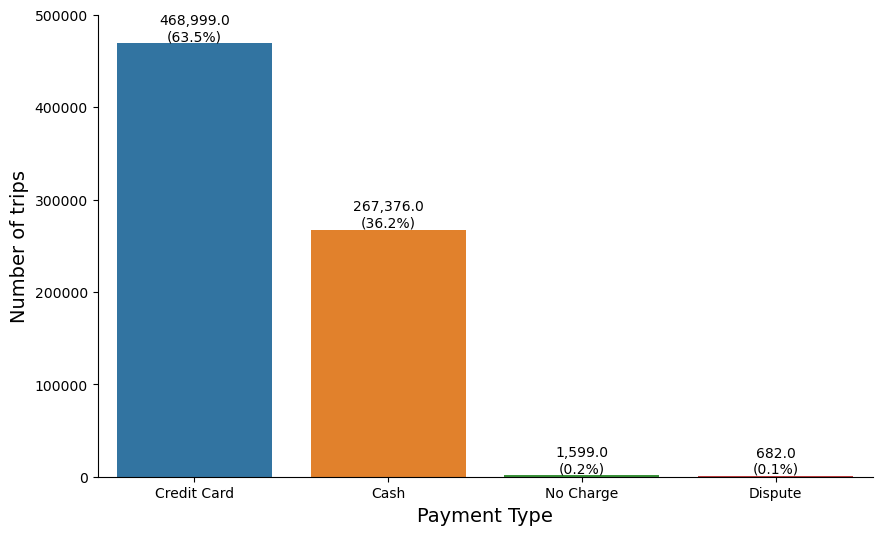

In [6]:
#Payment Type Distribution
plt.figure(figsize=(10, 6))
graph6 = sns.countplot(x = taxi_dataset['payment_type'], data=taxi_dataset)
graph6.set(xlabel='Payment Type', ylabel='Number of trips')
graph6.xaxis.label.set_fontsize(14)
graph6.yaxis.label.set_fontsize(14)
x = ['Credit Card', 'Cash', 'No Charge', 'Dispute']
graph6.set_xticklabels(x)

total = len(taxi_dataset['payment_type'])
for container in graph6.containers:
    for i, bar in enumerate(container):
        height = bar.get_height()
        graph6.text(bar.get_x() + bar.get_width()/2, height, f"{height:,}\n({height/total:.1%})", ha="center", va="bottom")

plt.ylim(0, 500000)

sns.despine()
plt.show()

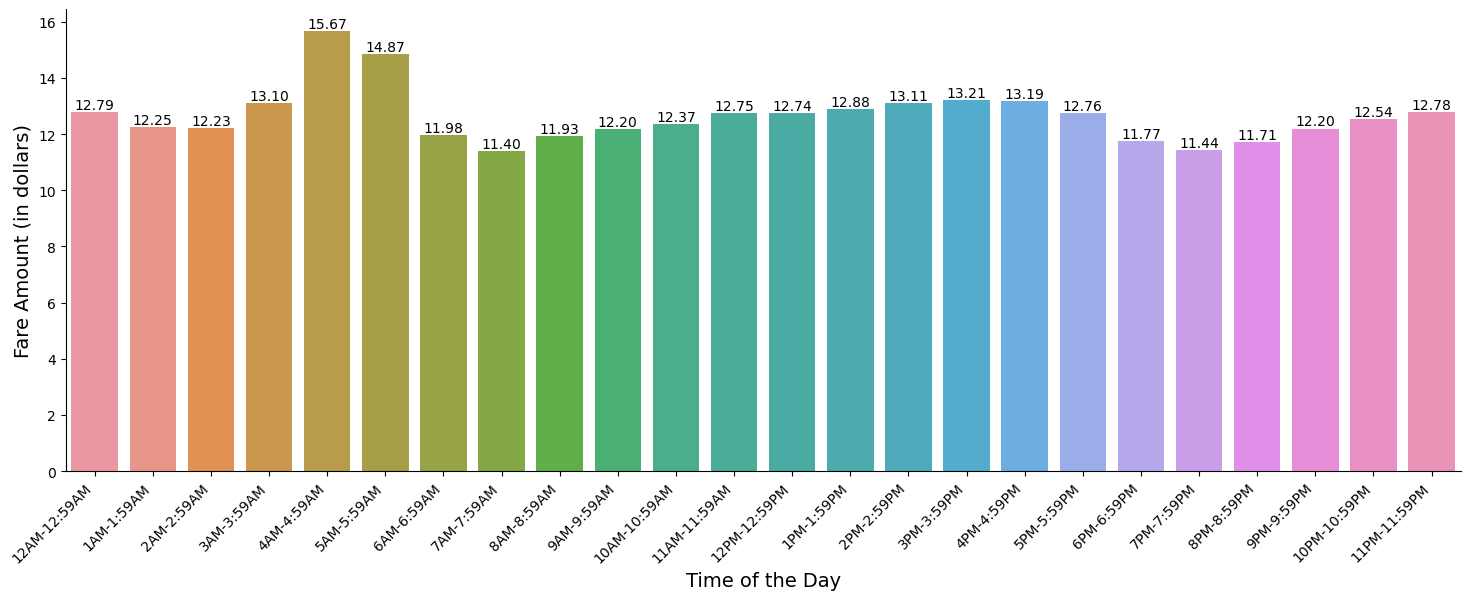

In [21]:
#Fare Amount Distribution
def add_bar_labels(barplot):
    for containers in barplot.containers:
        for bar in containers:
            height = bar.get_height()
            barplot.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha="center", va="bottom")

plt.figure(figsize=(18, 6))
graph7 = sns.barplot(x = taxi_dataset['tpep_pickup_datetime'].dt.hour, y = taxi_dataset['fare_amount'], data = taxi_dataset, errorbar = None)
plt.xlabel('Time of the Day', fontsize=14)
plt.ylabel('Fare Amount (in dollars)', fontsize=14)

tick_labels = [
    f"{i}AM-{i}:59AM" if i < 12 else 
    f"{i-12}PM-{i-12}:59PM" if i > 12 else 
    f"12AM-12:59AM"
    for i in range(24)
]
tick_labels[0] = "12AM-12:59AM"
tick_labels[12] = "12PM-12:59PM"

graph7.set_xticklabels(tick_labels, rotation=45, ha="right")

add_bar_labels(graph7)

sns.despine()
plt.show()

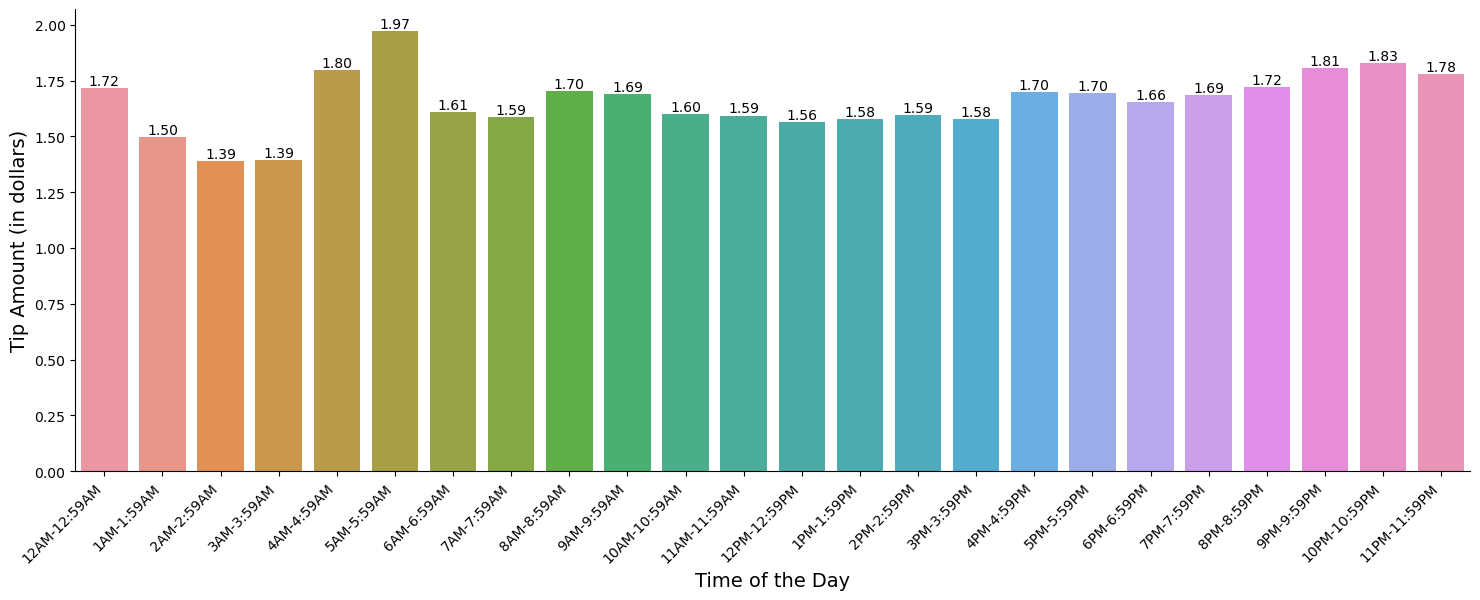

In [22]:
#Tip Amount Distribution
def add_bar_labels(barplot):
    for containers in barplot.containers:
        for bar in containers:
            height = bar.get_height()
            barplot.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha="center", va="bottom")

plt.figure(figsize=(18, 6))
graph7 = sns.barplot(x = taxi_dataset['tpep_pickup_datetime'].dt.hour, y = taxi_dataset['tip_amount'], data = taxi_dataset, errorbar = None)
plt.xlabel('Time of the Day', fontsize=14)
plt.ylabel('Tip Amount (in dollars)', fontsize=14)

tick_labels = [
    f"{i}AM-{i}:59AM" if i < 12 else 
    f"{i-12}PM-{i-12}:59PM" if i > 12 else 
    f"12AM-12:59AM"
    for i in range(24)
]
tick_labels[0] = "12AM-12:59AM"
tick_labels[12] = "12PM-12:59PM"

graph7.set_xticklabels(tick_labels, rotation=45, ha="right")

add_bar_labels(graph7)

sns.despine()
plt.show()

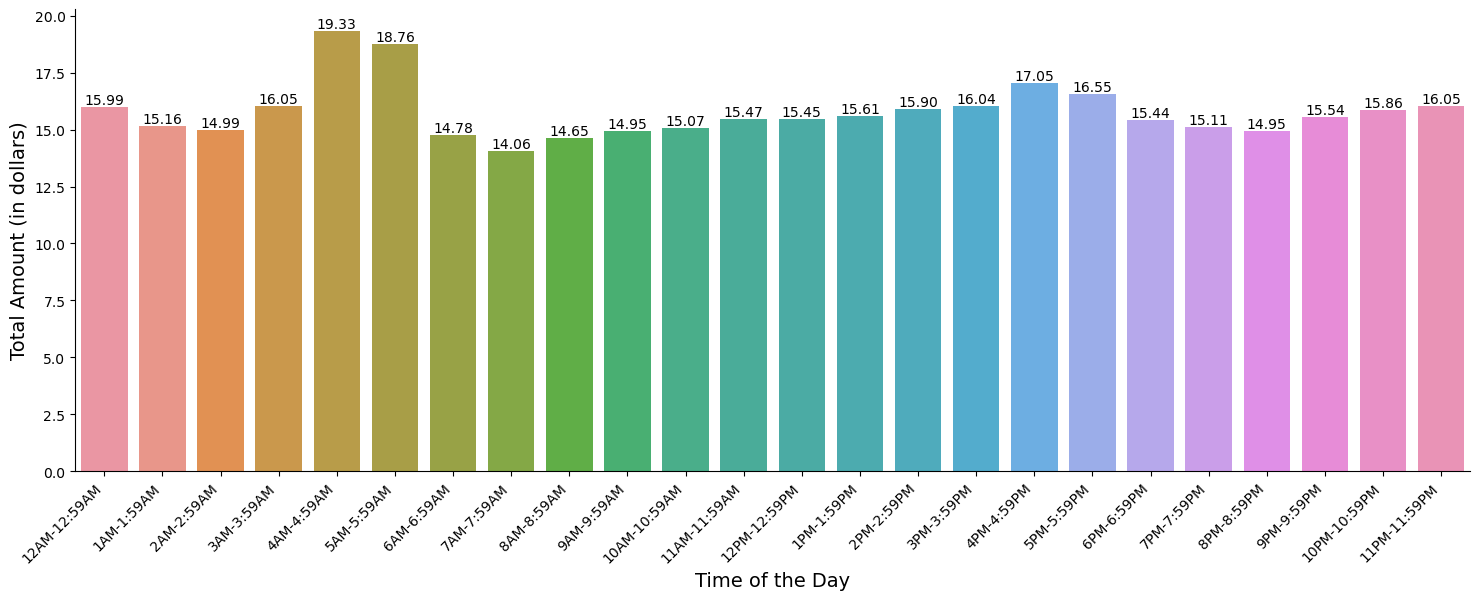

In [23]:
#Total Amount Distribution
def add_bar_labels(barplot):
    for containers in barplot.containers:
        for bar in containers:
            height = bar.get_height()
            barplot.text(bar.get_x() + bar.get_width()/2, height, f"{height:.2f}", ha="center", va="bottom")

plt.figure(figsize=(18, 6))
graph7 = sns.barplot(x = taxi_dataset['tpep_pickup_datetime'].dt.hour, y = taxi_dataset['total_amount'], data = taxi_dataset, errorbar = None)
plt.xlabel('Time of the Day', fontsize=14)
plt.ylabel('Total Amount (in dollars)', fontsize=14)

tick_labels = [
    f"{i}AM-{i}:59AM" if i < 12 else 
    f"{i-12}PM-{i-12}:59PM" if i > 12 else 
    f"12AM-12:59AM"
    for i in range(24)
]
tick_labels[0] = "12AM-12:59AM"
tick_labels[12] = "12PM-12:59PM"

graph7.set_xticklabels(tick_labels, rotation=45, ha="right")

add_bar_labels(graph7)

sns.despine()
plt.show()

Correlation between distance and: (1) duration, (2) amount

In [27]:
cor1 = taxi_dataset[['trip_distance', 'trip_duration']]
cor2 = taxi_dataset[['trip_distance', 'fare_amount']]
print(cor1.head())
print(cor2.head())

   trip_distance  trip_duration
0          17.45           26.0
1           0.40            2.0
2           1.50           11.0
4           7.50           25.0
5           1.61            7.0
   trip_distance  fare_amount
0          17.45         47.5
1           0.40          3.5
2           1.50          9.0
4           7.50         23.5
5           1.61          7.0


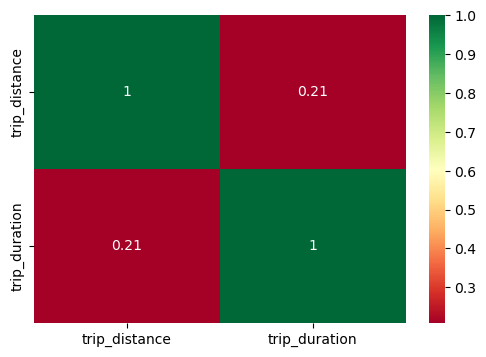

In [28]:
plt.figure(figsize=(6, 4))
plot = sns.heatmap(cor1.corr(), annot=True, cmap='RdYlGn')

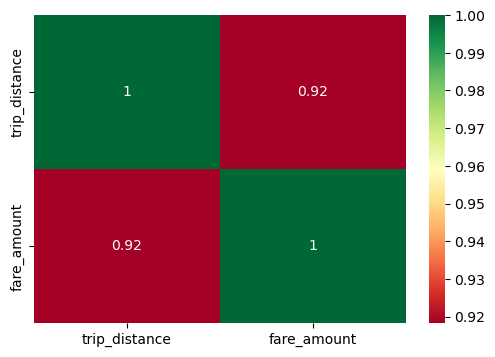

In [29]:
plt.figure(figsize=(6, 4))
plot = sns.heatmap(cor2.corr(), annot=True, cmap='RdYlGn')

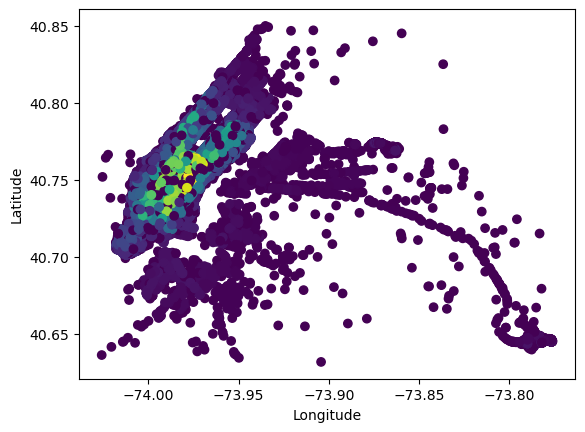

In [30]:
def plot_hdbscan_pickup(X, min_cluster_size=5, min_samples=1, gen_dmat=None):

    
    subset_indices = np.random.choice(range(X.shape[0]), size=int(X.shape[0] * 0.1), replace=False)
    X_subset = X[subset_indices, :]

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusterer.fit(X_subset)

    labels = clusterer.labels_
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    plt.scatter(X_subset[:, 0], X_subset[:, 1], c=labels, cmap="viridis")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

data = taxi_dataset[["pickup_longitude", "pickup_latitude"]].values

plot_hdbscan_pickup(data)

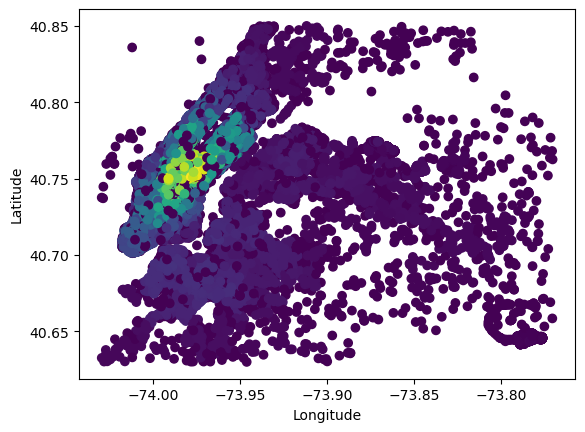

In [31]:
def plot_hdbscan_dropoff(X, min_cluster_size=5, min_samples=1, gen_dmat=None):

    
    subset_indices = np.random.choice(range(X.shape[0]), size=int(X.shape[0] * 0.1), replace=False)
    X_subset = X[subset_indices, :]

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusterer.fit(X_subset)

    labels = clusterer.labels_
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    plt.scatter(X_subset[:, 0], X_subset[:, 1], c=labels, cmap="viridis")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()



data = taxi_dataset[["dropoff_longitude", "dropoff_latitude"]].values

plot_hdbscan_dropoff(data)

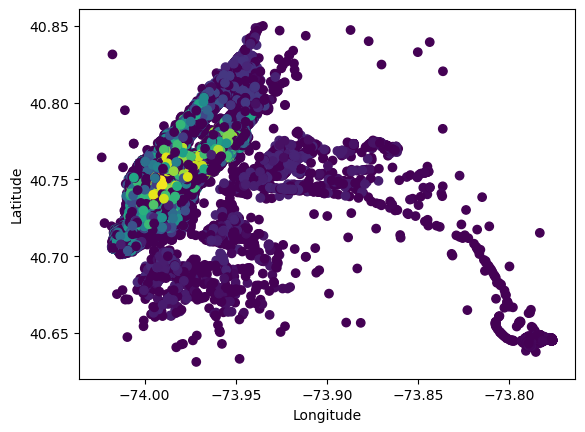

In [32]:
def plot_hdbscan_pickup_dropoff(X, min_cluster_size=5, min_samples=1, gen_dmat=None):

    
    subset_indices = np.random.choice(range(X.shape[0]), size=int(X.shape[0] * 0.1), replace=False)
    X_subset = X[subset_indices, :]

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusterer.fit(X_subset)

    labels = clusterer.labels_
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    plt.scatter(X_subset[:, 0], X_subset[:, 1], c=labels, cmap="viridis")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()



data = taxi_dataset[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]].values

plot_hdbscan_pickup_dropoff(data)


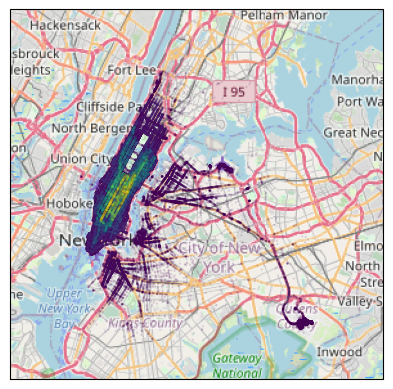

In [22]:
def plot_hdbscan_map_pickup(X, min_cluster_size=5, min_samples=1, gen_dmat=None):

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusterer.fit(X)

    labels = clusterer.labels_

    tiles = OSM()
    ax = plt.axes(projection=tiles.crs)
    ax.set_extent([-74.1, -73.7, 40.6, 40.9])

    ax.add_image(tiles, 10)

    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", transform=ccrs.PlateCarree(), s=0.5, alpha=0.1)

    plt.show()

data = taxi_dataset[["pickup_longitude", "pickup_latitude"]].values

plot_hdbscan_map_pickup(data)

c:\Users\Brent\anaconda3\lib\site-packages\cartopy\crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


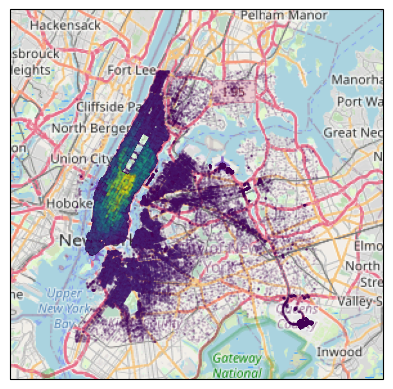

In [92]:
def plot_hdbscan_map_dropoff(X, min_cluster_size=5, min_samples=1, gen_dmat=None):

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusterer.fit(X)

    labels = clusterer.labels_

    tiles = OSM()
    ax = plt.axes(projection=tiles.crs)
    ax.set_extent([-74.1, -73.7, 40.6, 40.9])

    ax.add_image(tiles, 10)

    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", transform=ccrs.PlateCarree(), s=0.5, alpha=0.1)

    plt.show()

data = taxi_dataset[["dropoff_longitude", "dropoff_latitude"]].values

plot_hdbscan_map_dropoff(data)

c:\Users\Brent\anaconda3\lib\site-packages\cartopy\crs.py:814: DeprecationWarning: The 'geom_factory' function is deprecated in Shapely 2.0, and will be removed in a future version
  return cartopy.trace.project_linear(geometry, src_crs, self)


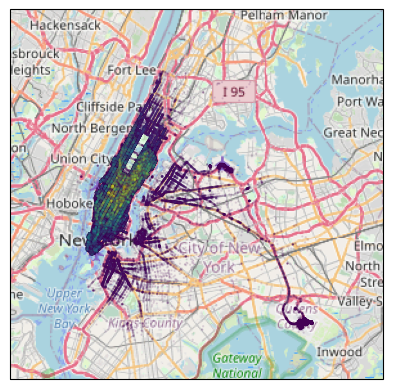

In [93]:
def plot_hdbscan_map_pickup_dropoff(X, min_cluster_size=5, min_samples=1, gen_dmat=None):

    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusterer.fit(X)

    labels = clusterer.labels_

    tiles = OSM()
    ax = plt.axes(projection=tiles.crs)
    ax.set_extent([-74.1, -73.7, 40.6, 40.9])

    ax.add_image(tiles, 10)

    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", transform=ccrs.PlateCarree(), s=0.5, alpha=0.1)

    plt.show()

data = taxi_dataset[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]].values

plot_hdbscan_map_pickup_dropoff(data)

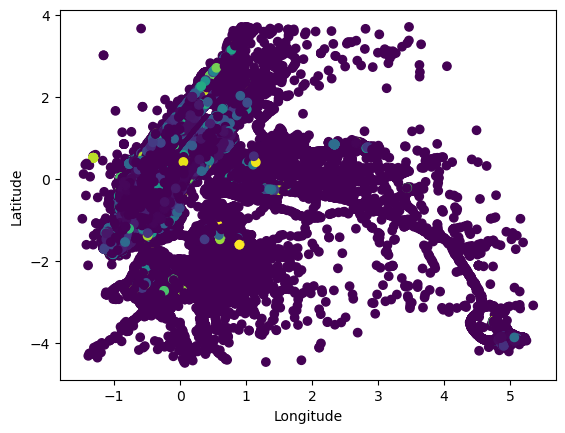

In [30]:
X = taxi_dataset[["pickup_longitude", "pickup_latitude"]]
X = StandardScaler().fit_transform(X)

dbscan = DBSCAN(eps=0.003, min_samples=10)
dbscan.fit(X)

labels = dbscan.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

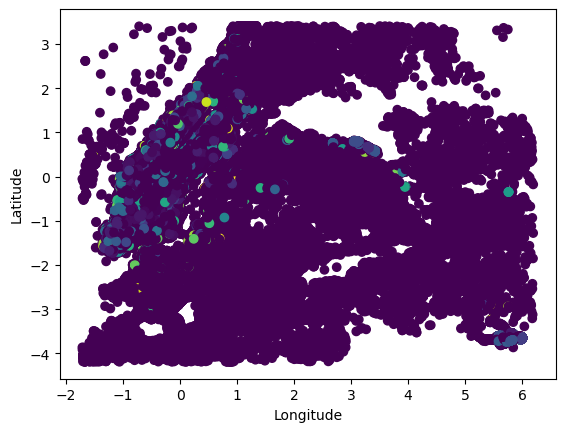

In [29]:
X = taxi_dataset[["dropoff_longitude", "dropoff_latitude"]]
X = StandardScaler().fit_transform(X)

dbscan = DBSCAN(eps=0.003, min_samples=10)
dbscan.fit(X)

labels = dbscan.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

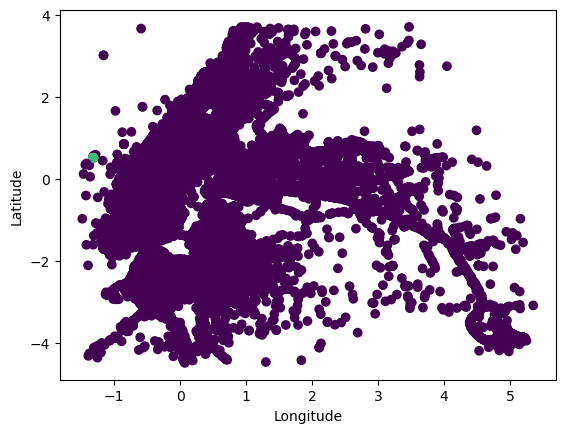

In [31]:
X = taxi_dataset[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]]
X = StandardScaler().fit_transform(X)

dbscan = DBSCAN(eps=0.003, min_samples=10)
dbscan.fit(X)

labels = dbscan.labels_
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

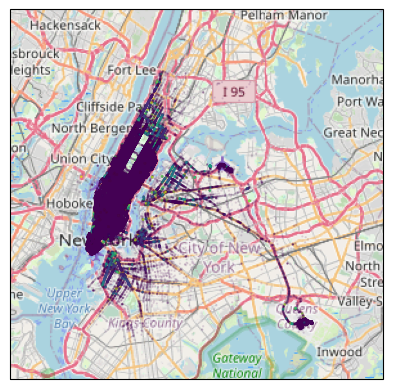

In [6]:
def plot_dbscan_map_pickup(X, eps=0.0003, min_samples=10):

    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    clusterer.fit(X)

    labels = clusterer.labels_

    tiles = OSM()
    ax = plt.axes(projection=tiles.crs)
    ax.set_extent([-74.1, -73.7, 40.6, 40.9])

    ax.add_image(tiles, 10)

    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", transform=ccrs.PlateCarree(), s=0.5, alpha=0.1)

    plt.show()

data = taxi_dataset[["pickup_longitude", "pickup_latitude"]].values

plot_dbscan_map_pickup(data)

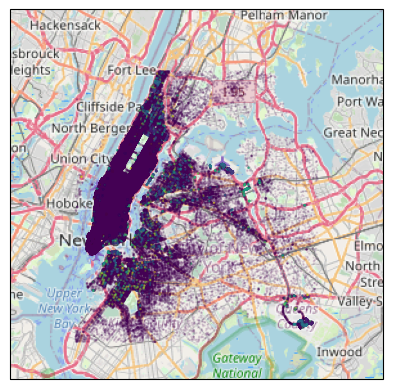

In [5]:
def plot_dbscan_map_dropoff(X, eps=0.0003, min_samples=10):

    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    clusterer.fit(X)
    
    labels = clusterer.labels_

    tiles = OSM()
    ax = plt.axes(projection=tiles.crs)
    ax.set_extent([-74.1, -73.7, 40.6, 40.9])

    ax.add_image(tiles, 10)

    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", transform=ccrs.PlateCarree(), s=0.5, alpha=0.1)

    plt.show()

data = taxi_dataset[["dropoff_longitude", "dropoff_latitude"]].values

plot_dbscan_map_dropoff(data)

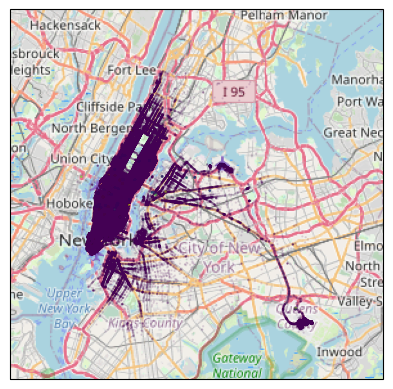

In [7]:
def plot_dbscan_map_pickup_dropoff(X, eps=0.0003, min_samples=10):

    clusterer = DBSCAN(eps=eps, min_samples=min_samples)
    clusterer.fit(X)

    labels = clusterer.labels_

    tiles = OSM()
    ax = plt.axes(projection=tiles.crs)
    ax.set_extent([-74.1, -73.7, 40.6, 40.9])

    ax.add_image(tiles, 10)

    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", transform=ccrs.PlateCarree(), s=0.5, alpha=0.1)

    plt.show()

data = taxi_dataset[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]].values

plot_dbscan_map_pickup_dropoff(data)

Map Only

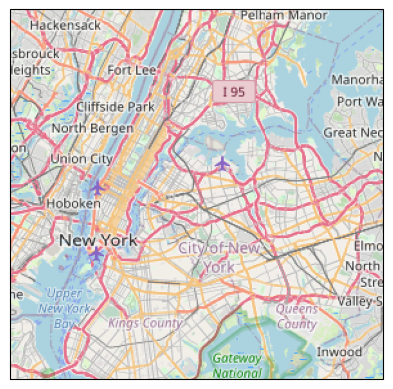

In [39]:
def plot_hdbscan_map_pickup_dropoff(X, min_cluster_size=5, min_samples=1, gen_dmat=None):

    tiles = OSM()
    ax = plt.axes(projection=tiles.crs)
    ax.set_extent([-74.1, -73.7, 40.6, 40.9])

    ax.add_image(tiles, 10)

    plt.show()

data = taxi_dataset[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]].values

plot_hdbscan_map_pickup_dropoff(data)